<a href="https://colab.research.google.com/github/eschjtrDE/UPLIMIT_Opensource_LLMs/blob/main/UPLIMIT_Opensource_LLMs_Week_3_Structuring_outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup and Opensource LLM

First, we will instantiate the open source LLM that we are going to use in the project. We will use the package LLama CPP.

In [ ]:
# Install the main python dependencies that we will use

!pip install langchain pydantic[email] ollama

In [ ]:
%%shell
# install Ollama, which we will use for LLM inference
curl https://ollama.ai/install.sh | sh
nohup ollama serve &

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8422    0  8422    0     0  10006      0 --:--:-- --:--:-- --:--:-- 10002>>> Downloading ollama...
100  8422    0  8422    0     0   9498      0 --:--:-- --:--:-- --:--:--  9494
############################################################################################# 100.0%
>>> Installing ollama to /usr/local/bin...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 0.0.0.0:11434.
>>> Install complete. Run "ollama" from the command line.
nohup: appending output to 'nohup.out'


### Download Notux Open source LLM

We will work with the Notux model. Feel free to experiment with other models ('phi' is very small and runs on cpu). However, the demos have been validated with Notux, so try the notebook before changing model

In [ ]:
!ollama pull notux
!ollama pull phi

Streaming output truncated to the last 5000 lines.
pulling ed11eda7790d... 100% ▕▏   30 B                         
pulling 835cf6b035e5... 100% ▕▏  484 B                         
verifying sha256 digest ⠇ pulling manifest 
pulling ed9002d88b83... 100% ▕▏  26 GB                         
pulling 002c2696d92b... 100% ▕▏ 1.1 KB                         
pulling 79b7eca19f7a... 100% ▕▏   43 B                         
pulling ed11eda7790d... 100% ▕▏   30 B                         
pulling 835cf6b035e5... 100% ▕▏  484 B                         
verifying sha256 digest ⠏ pulling manifest 
pulling ed9002d88b83... 100% ▕▏  26 GB                         
pulling 002c2696d92b... 100% ▕▏ 1.1 KB                         
pulling 79b7eca19f7a... 100% ▕▏   43 B                         
pulling ed11eda7790d... 100% ▕▏   30 B                         
pulling 835cf6b035e5... 100% ▕▏  484 B                         
verifying sha256 digest ⠋ pulling manifest 
pulling ed9002d88b83... 100% ▕▏  26 GB           

In [ ]:
import ollama

stream = ollama.chat(
    model='phi',
    messages=[{'role': 'user', 'content': 'Why is the sky blue?'}],
    stream=True,
)

for chunk in stream:
  print(chunk['message']['content'], end='', flush=True)

# 1. Basic Output Parsing

In [ ]:
prompt_template = """List population and coordinates of {place}"""
prompt = prompt_template.format(place="london")
output = ollama.generate(model="phi", prompt=prompt)
print(output["response"])

 Sure, I can help with that. 

London has a population of approximately 9 million people as of 2021. 

Coordinates for London are 51.5 degrees north latitude and 0.1 degrees west longitude. It is located on the River Thames in Southeast England.



# Exercise 1: Try to parse the output of the model

Warning! This exercise is a strawman, but it's useful to appreciate the complexity and reality of the task. You may succeed, you may not. Either way, you will learn how to consistently deal with this problem in the rest of the notebook.  

## 1. Define a use case that requires results in parameters

Define a use case, like the one above, that requires a response with separate parmeters. For example;

**Question**: `How many wheels and doors does a car have?`

**Answer**: Two Wheels and between 2 and 5 doors.

| Wheels | Doors |
|--------|-------|
| 4      | 2 to 5 |

This reponse has two parameters, doors and wheels. Imagine that you were building an apllication that structured a UI around this response. You would need to extract these parameters from the unstructured text.

## 2. Prompt the LLM for the reponse

Use prompt engineering techniques to encourage the model to respond in ways that is straightforward to parse. For example, you could request a CSV or JSON.

## 3. Parse the response

Use parsing and string manipulation to collect the parameters from the response.

In [ ]:
# SOLUTION !!!!



In [ ]:
# TODO: parse out the population and coordinates from the string

# 2. Pydantic Output Parsing

Let's move on to a reproducible approach to parsing outputs. We will use Pydantic Models. [Pydantic](https://docs.pydantic.dev/latest/) is a python package for data validation. It's use widely by python engineers for multiple use cases from typing http requests to building structured objects.

```python
from pydantic import BaseModel

class Person(BaseModel):
    name: str
    age: int
```

We will use `Pydantic` combined with `Langchain` to display to the language model the structure that we require, and then we will receive back a Pydantic object. We can then interact with the returned object using typical python object notation:

```python
barry = Person(name="Barry", age=52)
assert barry.age == 52
```

Let's explore how we implement this:

In [ ]:
from typing import Optional

from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field

Define the object and output parser, then create the `format_instructions` that will be presented to the language model.

In [ ]:
class City(BaseModel):
    nation: str = Field(description="The nation that the city is in")
    language: str = Field(description="The official language of the city")
    name: str= Field(description="The official name of the city")

output_parser = PydanticOutputParser(
    pydantic_object=City
)

format_instructions = output_parser.get_format_instructions()

Create a Langchain prompt template that combines input parameters and the format instructions.

In [ ]:
prompt = PromptTemplate(
    template="Instruct: Answer the user query as a structured output that conforms to the schema of the format_instructions, Do not return the schema itself: {query}. {format_instructions}\n Output: ",
    input_variables=["query"],
    partial_variables={"format_instructions": format_instructions},
)

_input = prompt.format_prompt(query="Largest city in the UK")
output = ollama.generate(model='notux', prompt=_input.to_string(), options={"num_ctx":4096, "temperature":0.5})

In [ ]:
print(_input)

text='Instruct: Answer the user query as a structured output that conforms to the schema of the format_instructions, Do not return the schema itself: Largest city in the UK. The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"nation": {"title": "Nation", "description": "The nation that the city is in", "type": "string"}, "language": {"title": "Language", "description": "The official language of the city", "type": "string"}, "name": {"title": "Name", "description": "The official name of the city", "type": "string"}}, "required": ["nation", "language", "name"]}\n```\n Outp

In [ ]:
output = output["response"]
print(output)

 {
"nation": "United Kingdom",
"language": "English",
"name": "London"
}


Now we can parse the output using the output parser.

In [ ]:
london = output_parser.parse(output)
london

City(nation='United Kingdom', language='English', name='London')

In [ ]:
london.language

'English'

# Exercise 2: Structure a business problem as a pydantic model

In this exercise you should scale up the pydantic model above to an (imagined) real-world business problem. For example, a product or a service.

## 1. Structure a real world entity as a Pydantic model

This example structures a software engineering team as a pydantic model:

```python
from pydantic import BaseModel, EmailStr
from typing import List, Optional

class Person(BaseModel):
    name: str
    email: EmailStr

class Developer(Person):
    programming_languages: List[str]

class QaEngineer(Person):
    tools: List[str]

class Designer(Person):
    design_tools: List[str]

class TeamLead(Person):
    years_of_experience: int

class SoftwareEngineeringTeam(BaseModel):
    team_lead: TeamLead
    developers: List[Developer]
    qa_engineers: List[QaEngineer]
    designers: Optional[List[Designer]]
```

Use the `EmailStr` type in your `BaseModel`.


In [ ]:
from pydantic import BaseModel, EmailStr # we can use a full range of pydantic's built in valitors
from typing import List, Optional # we can also use native python types

In [ ]:
# TODO: Define your business problem here

# Define a pydantic class that represents a business entity and use the type `EmailStr`

# # give your class as a parameter to the parser
# output_parser = PydanticOutputParser()

# # define an input query that returns your class

In [ ]:
# Solution !!!!

class Prospect(BaseModel):
    email: EmailStr = Field(description="Email address of the prospect")
    industry: str = Field(description="Business sector of the prospect")
    company: str = Field(description="The company where the prospect works")

output_parser = PydanticOutputParser(
    pydantic_object=Prospect
)

input_query="Yesterday I spoke to adam@uplimit.com that works in the education sector."

In [ ]:
format_instructions = output_parser.get_format_instructions()

prompt = PromptTemplate(
    template="Instruct: Answer the user query as a structured output that conforms to the schema of the format_instructions: {query}. {format_instructions}\n Output: ",
    input_variables=["query"],
    partial_variables={"format_instructions": format_instructions},
)

_input = prompt.format_prompt(query=input_query)
output = ollama.generate(model='notux', prompt=_input.to_string(), options={"num_ctx":4096, "temperature":0.5})

Once you have structured your output. Prompt the llm to populate the model. Note, you will probably need to iterate a few times over the pydantic model, and simplify it so that the LLM can effective unserstand the task.

In [ ]:
output["response"]

' {\n  "email": "adam@uplimit.com",\n  "industry": "education",\n  "company": "Uplimit"\n}'

In [ ]:
parsed_output = output_parser.parse(output["response"])
parsed_output

Prospect(email='adam@uplimit.com', industry='education', company='Uplimit')

Now let's see what happens when the model returns a incorrect response.

We will use the `EmailStr` type to check whether the parser detect an erroneous email adress.
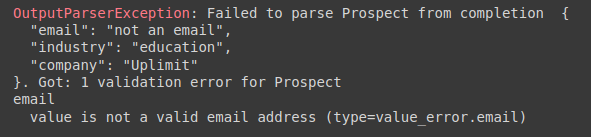

In [ ]:
try:
    bad_output = """ {\n  "email": "not an email",\n  "industry": "education",\n  "company": "Uplimit"\n}"""
    parsed_bad_output = output_parser.parse(bad_output)
except Exception as exc:
    print(exc)
    print("We caught it!!!")

Failed to parse Prospect from completion  {
  "email": "not an email",
  "industry": "education",
  "company": "Uplimit"
}. Got: 1 validation error for Prospect
email
  value is not a valid email address (type=value_error.email)
We caught it!!!


# 3. Guardrails

Let's move beyond the structure of the outputs and on to the content. The written content discusses the concept of guardrails and the various options for implementing them. We will use the python package `guardrails`.  

In [ ]:
!pip install git+https://github.com/guardrails-ai/guardrails.git@main

## 3.1 Validating outputs with guardrails

Guardrails comes with a few built in validators that validate outputs against generic critera. For example `BugFreePython` that validates the output is working python.

In [ ]:
from guardrails import Guard
from guardrails.validators import BugFreePython
from rich import print
import ollama

guard = Guard.from_string(
    validators=[BugFreePython(on_fail="reask")],
    description="Python code that runs",
    prompt="Generate python code for a flask API"
)


In [ ]:
def generate(text, **kwargs):
    # Simple inference example
    return ollama.generate(model='phi', prompt=text)["response"]

validated_llm_response = guard(generate)

In [ ]:
print(validated_llm_response)

ValidationOutcome(
    raw_llm_output=' \n```python\ndef route_handler():\n    return "Welcome to our API"\n\ndef 
handle_requests(request):\n    # Code for handling requests here\n    pass\n\ndef custom_error_handler(error):\n   
# Code for error handling here\n    pass\n\ndef log_data_to_file(data):\n    # Code for logging data here\n    
pass\n```\nThis code generates a Flask API with route handler, function to handle requests, custom error handler 
and function for logging data. It does not contain any syntax errors and correctly implements the functionality you
described.\n\n',
    validated_output=None,
    reask=FieldReAsk(
        incorrect_value=' \n```python\ndef route_handler():\n    return "Welcome to our API"\n\ndef 
handle_requests(request):\n    # Code for handling requests here\n    pass\n\ndef custom_error_handler(error):\n   
# Code for error handling here\n    pass\n\ndef log_data_to_file(data):\n    # Code for logging data here\n    
pass\n```\nThis code generates a Flask API with route handler, function to handle requests, custom error handler 
and function for logging data. It does not contain any syntax errors and correctly implements the functionality you
described.\n\n',
        fail_results=[
            FailResult(
                outcome='fail',
                metadata=None,
                error_message='Syntax error: invalid syntax',
                fix_value=None
            )
        ],
        path=None
    ),
    validation_passed=False,
    error=None
)

## 3.2 Validating outputs with Guardrails + Pydantic Models

Similarly to langchain, Guardrails can use `Pydantic` to represent outputs. However, Guardrails can include more information for the model to involve in its generation.

In [ ]:
from guardrails.validators import ValidLength, TwoWords
from rich import print

class Pet(BaseModel):
    pet_type: str = Field(description="Species of pet")
    name: str = Field(description="a unique pet name", validators=[ValidLength(min=8, max=32, on_fail='reask')])

prompt = """
    What kind of pet should I get and what should I name it?

    ${gr.complete_json_suffix_v2}
"""

guard = Guard.from_pydantic(output_class=Pet, prompt=prompt)

validated_llm_response = guard(generate)

print(validated_llm_response)

ValidationOutcome(
    raw_llm_output=' Sure! Here\'s a Python code snippet that can help solve this problem: \n```python\nimport 
xml.etree.ElementTree as ET\nimport json\n\nxml_doc = \'\'\'<output>\n                <string name="pet_type" 
description="Species of pet"/>\n                <string name="name" description="a unique pet name" format="length:
min=8 max=32"/>\n            </output>\'\'\'\ntree = ET.fromstring(xml_doc)\nxml_root = tree.getroot()\n\npet_type 
= xml_root[0].text\nname = json.loads(xml_root[1].text)["name"]\nname["length"] = "8" # changing the format of name
attribute to be shorter than 32 characters\n\ncorrected_dict = {\n    "pet_type": pet_type,\n    "name": 
name,\n}\ncorrected_xml = json.dumps(corrected_dict)\n\nprint("The corrected JSON object is:", 
json.loads(corrected_xml))\n```\nThis code first converts the XML document into a tree structure using 
`ElementTree`. Then it extracts the `pet_type` and `name` from the root element of the tree, and uses 
`json.loads()` to convert the `name` attribute to be shorter than 32 characters (if it is currently longer). 
Finally, it creates a new dictionary with the corrected values and converts it back to JSON using 
`json.dumps()`.\n',
    validated_output=None,
    reask=NonParseableReAsk(
        incorrect_value=' Sure! Here\'s a Python code snippet that can help solve this problem: \n```python\nimport
xml.etree.ElementTree as ET\nimport json\n\nxml_doc = \'\'\'<output>\n                <string name="pet_type" 
description="Species of pet"/>\n                <string name="name" description="a unique pet name" format="length:
min=8 max=32"/>\n            </output>\'\'\'\ntree = ET.fromstring(xml_doc)\nxml_root = tree.getroot()\n\npet_type 
= xml_root[0].text\nname = json.loads(xml_root[1].text)["name"]\nname["length"] = "8" # changing the format of name
attribute to be shorter than 32 characters\n\ncorrected_dict = {\n    "pet_type": pet_type,\n    "name": 
name,\n}\ncorrected_xml = json.dumps(corrected_dict)\n\nprint("The corrected JSON object is:", 
json.loads(corrected_xml))\n```\nThis code first converts the XML document into a tree structure using 
`ElementTree`. Then it extracts the `pet_type` and `name` from the root element of the tree, and uses 
`json.loads()` to convert the `name` attribute to be shorter than 32 characters (if it is currently longer). 
Finally, it creates a new dictionary with the corrected values and converts it back to JSON using 
`json.dumps()`.\n',
        fail_results=[
            FailResult(
                outcome='fail',
                metadata=None,
                error_message='Output is not parseable as JSON',
                fix_value=None
            )
        ]
    ),
    validation_passed=False,
    error='Expecting value: line 1 column 1 (char 0)'
)

# Exercise 3: Basic Guardrails with Pydantic Class with Custom Validator

In this exercise you will combine your real world business model with guardrails by validating the model output against the pydantic model.

**Objective**: Create a Pydantic model to represent a Vehicle and validate its attributes using Guardrails and custom validators.


**Task**: Define a Pydantic class Vehicle with the following attributes:

type: a string field representing the type of vehicle (e.g., car, truck, motorcycle).
model: a string field representing the model of the vehicle.
year: an integer field representing the year of manufacture.
Implement a custom validator for the year field to ensure it is within a reasonable range (e.g., 1900 to the current year).

Set up a Guardrails Guard using the Vehicle class, with a prompt asking the LLM to suggest a vehicle, including its type, model, and year. Ensure the prompt ends with ${gr.complete_json_suffix_v2} for structured JSON output.

Test the Guard with various inputs to demonstrate both successful validations and scenarios where the custom validator triggers a failure.

Hints:

Review the Pydantic documentation on custom validators (e.g., @validator decorator).

Ensure your custom validator handles edge cases, such as future years or non-integer inputs.


In [ ]:
### SOLUTION !!!

from pydantic import BaseModel, Field, validator
from pydantic import ValidationError
from datetime import datetime
from guardrails import Guard

class Vehicle(BaseModel):
    type: str = Field(description="Type of vehicle (e.g., car, truck, motorcycle)")
    model: str = Field(description="Model of the vehicle")
    year: int = Field(description="Year of manufacture")

    @validator('year')
    def year_must_be_realistic(cls, v):
        current_year = datetime.now().year
        if v < 1900 or v > current_year:
            print(v)
            raise ValidationError('Year must be between 1900 and the current year')
        return v


In [ ]:
prompt = """
    Suggest a vehicle for me, including its type, model, and year.

    ${gr.complete_json_suffix_v2}
"""

guard = Guard.from_pydantic(output_class=Vehicle, prompt=prompt)

/usr/local/lib/python3.10/dist-packages/guardrails/utils/pydantic_utils/v1.py:163: UserWarning: Validator year_must_be_realistic is defined as a method in the BaseModel. This is not supported by Guardrails. Please define the validator using the `add_validator` function.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/guardrails/validatorsattr.py:292: UserWarning: Validator year_must_be_realistic is not valid for element integer.
  warnings.warn(


In [ ]:
import json


def test_vehicle_guard(guard):
    test_cases = [
        ({"type": "car", "model": "Tesla Model S", "year": 2022}, True),  # Valid case
        ({"type": "truck", "model": "Ford F-150", "year": 1899}, False), # Invalid year (too early)
        ({"type": "motorcycle", "model": "Harley-Davidson", "year": 2100}, False), # Invalid year (too late)
        ({"type": "car", "model": "Toyota Corolla", "year": "not a year"}, False), # Invalid year (not an integer)
    ]

    for idx, (simulated_response, should_pass) in enumerate(test_cases):
        # Mocking the LLM API response
        def llm_api_mock(*args, **kwargs):
            return json.dumps(simulated_response)

        try:
            raw_llm_output, validated_output, *rest = guard(simulated_response)
            if not should_pass:
                print(f"Test case {idx + 1} failed: Expected validation error, but got: {validated_output}")
            else:
                print(f"Test case {idx + 1} passed")
        except ValidationError as e:
            if should_pass:
                print(f"Test case {idx + 1} failed: Unexpected validation error: {e}")
            else:
                print(f"Test case {idx + 1} passed with expected validation error: {e}")

# Example usage of the test function
test_vehicle_guard(guard)


Test case 1 failed: Unexpected validation error: 1 validation error for CallInputs
llm_api
  {'type': 'car', 'model': 'Tesla Model S', 'year': 2022} is not callable (type=type_error.callable; value={'type':
'car', 'model': 'Tesla Model S', 'year': 2022})

Test case 2 passed with expected validation error: 1 validation error for CallInputs
llm_api
  {'type': 'truck', 'model': 'Ford F-150', 'year': 1899} is not callable (type=type_error.callable; value={'type': 
'truck', 'model': 'Ford F-150', 'year': 1899})

Test case 3 passed with expected validation error: 1 validation error for CallInputs
llm_api
  {'type': 'motorcycle', 'model': 'Harley-Davidson', 'year': 2100} is not callable (type=type_error.callable; 
value={'type': 'motorcycle', 'model': 'Harley-Davidson', 'year': 2100})

Test case 4 passed with expected validation error: 1 validation error for CallInputs
llm_api
  {'type': 'car', 'model': 'Toyota Corolla', 'year': 'not a year'} is not callable (type=type_error.callable; 
value={'type': 'car', 'model': 'Toyota Corolla', 'year': 'not a year'})

# Exercise 4: Nested Pydantic Structures with Validators

Objective: Expand your understanding of Pydantic and Guardrails by creating a nested structure representing a Library with books and authors.

Task:

Define two Pydantic classes:

Author: with attributes name (string) and nationality (string).
Book: with attributes title (string), genre (string), and author (nested Author object).
Add validators to ensure:

name in Author is not empty and does not exceed 50 characters.
title in Book is not empty and does not exceed 100 characters.
The genre in Book matches a predefined list of genres (e.g., "Fiction", "Non-fiction", "Mystery").
Create a Pydantic class Library with a single field books, which is a list of Book objects.

Set up a Guardrails Guard using the Library class, with a prompt asking the LLM to suggest a list of books with titles, genres, and author details. Ensure the prompt ends with ${gr.complete_json_suffix_v2}.

Test the Guard with various inputs to demonstrate the validation of nested structures and the effectiveness of your validators.

Hints:

Explore the use of List in Pydantic for defining a list of objects.
Ensure your validators provide meaningful error messages for easier debugging.
Consider edge cases, such as empty lists or invalid genres.
Both exercises are designed to test your understanding of Pydantic's capabilities, including field definitions, custom validators, and nested structures, as well as integrating these with Guardrails for structured LLM outputs.


In [ ]:
### SOLUTION !!!

from pydantic import BaseModel, Field, validator, ValidationError
from typing import List
from guardrails import Guard
import openai
import json

# Author class
class Author(BaseModel):
    # \ add attributes
    @validator('name')
    def name_must_be_valid(cls, v):
        pass

# Book class
class Book(BaseModel):
    title: str = Field(description="Title of the book")
    genre: str = Field(description="Genre of the book")
    author: Author = Field(description="Author of the book")

    @validator('title')
    def title_must_be_valid(cls, v):
        if not v or len(v) > 100:
            raise ValidationError('Title must be non-empty and not exceed 100 characters')
        return v

    @validator('genre')
    def genre_must_be_valid(cls, v):
        valid_genres = ["Fiction", "Non-fiction", "Mystery"]
        if v not in valid_genres:
            raise ValidationError(f'Genre must be one of {valid_genres}')
        return v

# Library class
class Library(BaseModel):
    books: List[Book] = Field(description="List of books in the library")

prompt = """
    Suggest a list of books with their titles, genres, and author details.

    ${gr.complete_json_suffix_v2}
"""

guard = Guard.from_pydantic(output_class=Library, prompt=prompt)


<ipython-input-321-7073c2bddc18>:14: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.6/migration/
  @validator('name')
<ipython-input-321-7073c2bddc18>:26: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.6/migration/
  @validator('title')
<ipython-input-321-7073c2bddc18>:32: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more det

In [ ]:
#### TEST FUNCTION

def test_library_guard(guard):
    test_cases = [
        ({"books": [{"title": "1984", "genre": "Fiction", "author": {"name": "George Orwell", "nationality": "British"}}]}, True),
        ({"books": [{"title": "The Catcher in the Rye", "genre": "Fantasy", "author": {"name": "J.D. Salinger", "nationality": "American"}}]}, False),
        ({"books": [{"title": "L" * 101, "genre": "Fiction", "author": {"name": "Some Author", "nationality": "Some Nationality"}}]}, False),
    ]

    for idx, (simulated_response, should_pass) in enumerate(test_cases):
        # Mocking the LLM API response
        def llm_api_mock(*args, **kwargs):
            return json.dumps(simulated_response)

        try:
            raw_llm_output, validated_output, *rest = guard(llm_api_mock)
            if not should_pass:
                print(f"Test case {idx + 1} failed: Expected validation error, but got: {validated_output}")
            else:
                print(f"Test case {idx + 1} passed")
        except Exception as e:
            if should_pass:
                print(f"Test case {idx + 1} failed: Unexpected validation error: {e}")
            else:
                print(f"Test case {idx + 1} passed with expected validation error: {e}")

# Example usage of the test function
test_library_guard(guard)


Test case 1 passed

Test case 2 failed: Expected validation error, but got: None

Test case 3 failed: Expected validation error, but got: None

# The End 💐

Well done! You have completed the third project.

